In [3]:
import os
import cv2
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
data_dir = 'C:/Users/dhill/VS-Code/dataset'
categories = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Function to apply Gaussian blur
def apply_gaussian_blur(image, ksize=(5, 5)):
    return cv2.GaussianBlur(image, ksize, 0)

# Function to apply histogram equalization
def apply_histogram_equalization(image):
    if len(image.shape) == 2:  # Grayscale image
        return cv2.equalizeHist(image)
    else:  # Color image
        ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

# Function to adjust intensity thresholds
def adjust_intensity(image, low=0, high=255):
    return cv2.normalize(image, None, alpha=low, beta=high, norm_type=cv2.NORM_MINMAX)

# Function to load and preprocess images
def load_and_preprocess_images(data_dir, categories, img_size=(105, 105), enhance=False):
    data = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                if enhance:
                    # Apply Gaussian blur
                    img_array = apply_gaussian_blur(img_array)
                    # Apply histogram equalization
                    img_array = apply_histogram_equalization(img_array)
                    # Adjust intensity thresholds
                    img_array = adjust_intensity(img_array)
                resized_array = cv2.resize(img_array, img_size)
                data.append([resized_array, class_num])
            except Exception as e:
                pass
    return data

# Load and preprocess images
data = load_and_preprocess_images(data_dir, categories)

# Shuffle the data
random.shuffle(data)

# Select 1000 images for training and 200 images for testing
train_data = data[:2000]
test_data = data[2000:2400]

# Split data and labels for training and testing
X_train = []
y_train = []
X_test = []
y_test = []

for features, label in train_data:
    X_train.append(features)
    y_train.append(label)

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

X_train = np.array(X_train).reshape(-1, 105, 105, 3) / 255.0  # Scaling
y_train = np.array(y_train)
X_test = np.array(X_test).reshape(-1, 105, 105, 3) / 255.0    # Scaling
y_test = np.array(y_test)

# Convert X_train to uint8 before applying image enhancement
X_train_uint8 = (X_train * 255).astype(np.uint8)

# Apply image enhancement techniques to the training data only
X_train_enhanced = np.array([apply_gaussian_blur(img) for img in X_train_uint8])
X_train_enhanced = np.array([apply_histogram_equalization(img) for img in X_train_enhanced])
X_train_enhanced = np.array([adjust_intensity(img) for img in X_train_enhanced])

# Rescale enhanced images back to range [0, 1]
X_train_enhanced = X_train_enhanced / 255.0


In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train_enhanced)


In [16]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(105, 105, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')

])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Calculate the training time
start_time = time.time()

# Training the model
history = model.fit(datagen.flow(X_train_enhanced, y_train, batch_size=32), epochs=80, validation_data=(X_test, y_test))

end_time = time.time()
training_time = end_time - start_time

print(f"Training Time: {training_time:.2f} seconds")

Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.2405 - loss: 1.7309 - val_accuracy: 0.2300 - val_loss: 1.7029
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2572 - loss: 1.6921 - val_accuracy: 0.2850 - val_loss: 1.6727
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2582 - loss: 1.6729 - val_accuracy: 0.2850 - val_loss: 1.6346
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2700 - loss: 1.6292 - val_accuracy: 0.2875 - val_loss: 1.6297
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2697 - loss: 1.6304 - val_accuracy: 0.2600 - val_loss: 1.6362
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2803 - loss: 1.6149 - val_accuracy: 0.2575 - val_loss: 1.6000
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2602 - loss: 1.6031 - val_accuracy: 0.2975 - val_loss: 1.5759
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2834 - loss: 1.5507 - val_accuracy: 0.2800 - v

In [19]:
model.save('cnn_model.h5')


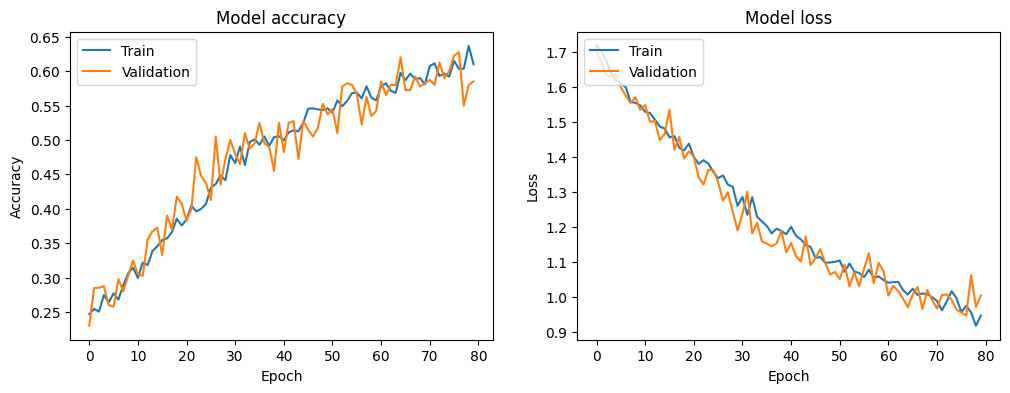

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


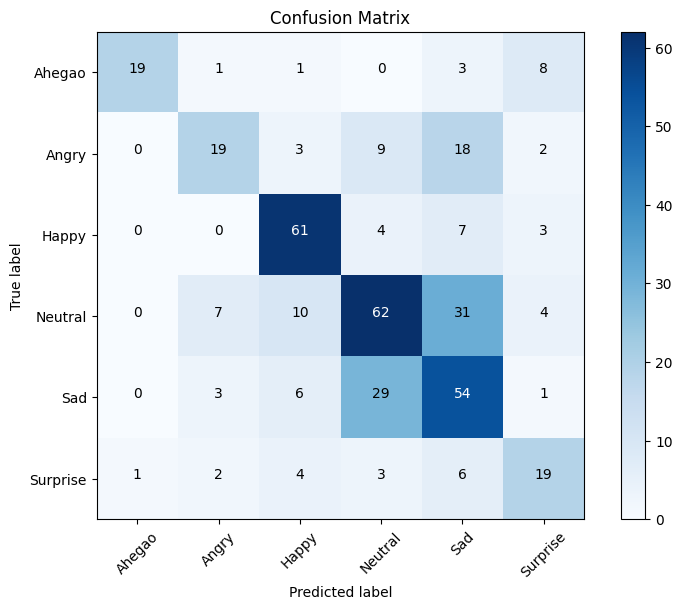

              precision    recall  f1-score   support

      Ahegao       0.95      0.59      0.73        32
       Angry       0.59      0.37      0.46        51
       Happy       0.72      0.81      0.76        75
     Neutral       0.58      0.54      0.56       114
         Sad       0.45      0.58      0.51        93
    Surprise       0.51      0.54      0.53        35

    accuracy                           0.58       400
   macro avg       0.63      0.57      0.59       400
weighted avg       0.60      0.58      0.58       400



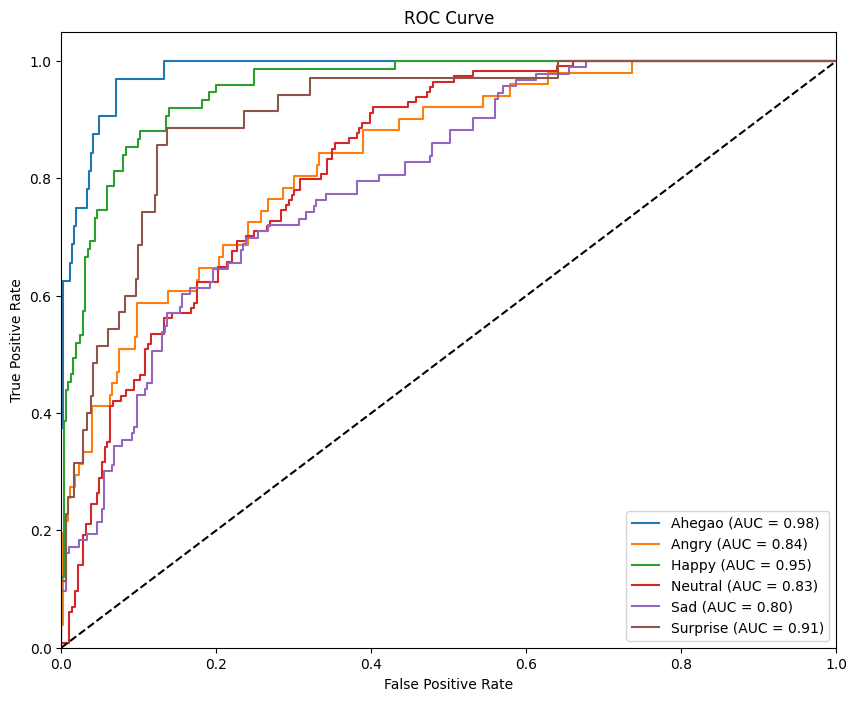

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predict the values from the test dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

# Adding the numbers to the confusion matrix
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=categories))

# ROC and AUC
y_test_bin = label_binarize(y_test, classes=range(6))
y_pred_bin = label_binarize(y_pred_classes, classes=range(6))

plt.figure(figsize=(10, 8))
for i in range(6):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{categories[i]} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

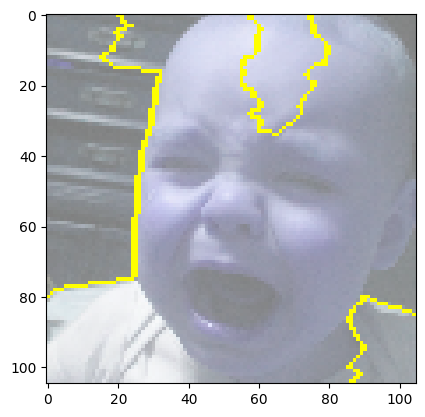

In [18]:
from lime import lime_image

# Using LIME for interpretability
explainer = lime_image.LimeImageExplainer()

# Select a random image for explanation
sample_image = X_test[0]
explanation = explainer.explain_instance(sample_image, model.predict, top_labels=1, hide_color=0, num_samples=1000)

# Display the explanation
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()